<a href="https://colab.research.google.com/github/xslittlemaggie/Deep-Learning-Projects/blob/master/Dogs_cats_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Kaggle Project: Cats & Dogs CNN </center></h1>

## Step 0. Import library

In [1]:
# libraries for files
import os
import glob
import cv2

# libraries for image processing and NN models
import numpy as np
import pandas as pd
import random

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Dense, Activation, Flatten
from keras.optimizers import SGD, adam, RMSprop

Using TensorFlow backend.


## Step 1. Load data from Kaggle

#### 1. Get the username, key from kaggle

In [0]:
os.environ['KAGGLE_USERNAME'] = "maggie" # username from the json file 
os.environ['KAGGLE_KEY'] = "7adfc6c4e6c5eec087031fbb7397aee" # key from the json file (This key is incorrect5)

#### 2. Find the dataset from Kaggle 

In [0]:
#!pip install kaggle
!pip install -q kaggle

In [7]:
!kaggle datasets list -s dogs-vs-cats  # It will list the 20 datasets including "dogs-vs-cats" from kaggle

ref                                                   title                                               size  lastUpdated          downloadCount  
----------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
biaiscience/dogs-vs-cats                              Dogs vs Cats                                       814MB  2017-12-05 14:03:33           2010  
nafisur/dogs-vs-cats                                  Dogs_vs_cats                                       217MB  2018-04-25 08:01:49           1632  
dhirensk/cats-vs-dogs-training8000test2000            Cats vs Dogs Training8000Test2000                  218MB  2018-11-21 09:38:07            135  
salader/dogs-vs-cats                                  dogs vs cats                                       545MB  2018-11-30 19:31:13            431  
tongpython/cat-and-dog                                Cat and Dog                                        2

The dataset of interest is:  **biaiscience/dogs-vs-cats**

#### 3. Get the particular dataset from the previous step, and download data from Kaggle

In [0]:
!kaggle datasets download -d biaiscience/dogs-vs-cats -p /content/

 98% 797M/814M [00:14<00:00, 26.6MB/s]
100% 814M/814M [00:14<00:00, 60.2MB/s]


#### 4.  Upzip data to file

In [0]:
!unzip -q /content/dogs-vs-cats.zip -d /content/dogs-vs-cats/
!unzip -q /content/dogs-vs-cats/train.zip -d /content/dogs-vs-cats/
!unzip -q /content/dogs-vs-cats/test.zip -d /content/dogs-vs-cats/

#### 5. Get familiar with how the dataset look like

In [0]:
# train datasets
pathes_train = glob.glob('/content/dogs-vs-cats/train/*.jpg')
print("The file name for images in training data file:"+"\n",pathes_train[0])
print("Training size:", len(pathes_train), "\n")

# test datasets
pathes_test = glob.glob('/content/dogs-vs-cats/test/*.jpg')
print("The file name for images in testing data file:"+"\n",pathes_test[0])
print("Testing size:", len(pathes_test))

The file name for images in training data file:
 /content/dogs-vs-cats/train/cat.2151.jpg
Training size: 25000 

The file name for images in testing data file:
 /content/dogs-vs-cats/test/7381.jpg
Testing size: 12500


#### 6. Create subfiles from training, validation, and testing files

In [0]:
# splits pictures into cats and dogs files for train dataset
os.mkdir("/content/dogs-vs-cats/train/cats")
os.mkdir("/content/dogs-vs-cats/train/dogs")

# create validation file to store validation dataset
os.mkdir("/content/dogs-vs-cats/validation")

os.mkdir("/content/dogs-vs-cats/validation/cats")
os.mkdir("/content/dogs-vs-cats/validation/dogs")

# create subfile from test to store testing dataset
os.mkdir("/content/dogs-vs-cats/test/unlabelled")

#### 7. Split the pictures in train file into subfiles: cats and dogs

We get 1 big file, "dogs-vs-cats", and two subfiles **train** file, and **test** file.  
1. The **train** file includes 25000 pictures, either cats or dogs. 
2. Two subfiles, **cats** and **dogs**  are created in **train** file.
3. All images with the file name including **cat** are moved to the **cats** file under **train** file, and all images with the file name including **dog** are moved to the **dogs** file under **train** file.

In [0]:
# move all pictures labelled "cat" to "/cat/s" file and all picture labelled "dog" to "/dogs/" file in training
pathes = glob.glob('/content/dogs-vs-cats/train/*.jpg')
for path in pathes:
  head, tail = os.path.split(path)
  if tail[:3] == "cat":
    new_path = head + "/cats/" + tail  
  else:
    new_path = head + "/dogs/" + tail
  os.rename(path, new_path)

In [0]:
# move all pictures from testing file to test subfile "/unlabelled/" for predicting later
pathes = glob.glob('/content/dogs-vs-cats/test/*.jpg')
for path in pathes:
  head, tail = os.path.split(path)
  new_path = head + "/unlabelled/" + tail
  os.rename(path, new_path)

#### 8. Randomly move 10% pictures in train file into validation file

In [0]:
# cats in validation data
cats_pathes = glob.glob('/content/dogs-vs-cats/train/cats/*.jpg') 
val_cats_idx = random.sample((range(12500)), k = 1250)
val_cats = [cats_pathes[idx] for idx in val_cats_idx]

for path in val_cats:
  head, tail = os.path.split(path)  
  new_path = head[:-10] + "validation/cats/" + tail 
  os.rename(path, new_path)  

# dogs in validation data
dogs_pathes = glob.glob('/content/dogs-vs-cats/train/dogs/*.jpg') 
val_dogs_idx = random.sample((range(12500)), k = 1250)
val_dogs = [dogs_pathes[idx] for idx in val_dogs_idx]

for path in val_dogs:
  head, tail = os.path.split(path)  
  new_path = head[:-10] + "validation/dogs/" + tail 
  os.rename(path, new_path)  

## Step 2. Data preprocessing for training & validating datasets

#### 1. Get familar with the input (image) from training files, validation file and testing file. 

In [0]:
DATADIR_train = "/content/dogs-vs-cats/train"
DATADIR_validation = "/content/dogs-vs-cats/validation"
DATADIR_test = "/content/dogs-vs-cats/test"

In [0]:
# train file
train_dogs_dir = os.path.join(DATADIR_train, "dogs")
train_cats_dir = os.path.join(DATADIR_train, "cats")
train_dog_fnames = os.listdir(train_dogs_dir)
train_cat_fnames = os.listdir(train_cats_dir)

print("Images from Training file:")
print("cats:", train_cat_fnames[:5])
print("dogs:", train_dog_fnames[:5])
print('total training cat images :', len(train_cat_fnames))
print('total training dog images :', len(train_dog_fnames ))
print()

# validation file
validation_dogs_dir = os.path.join(DATADIR_validation, "dogs")
validation_cats_dir = os.path.join(DATADIR_validation, "cats")
validation_dog_fnames = os.listdir(validation_dogs_dir)
validation_cat_fnames = os.listdir(validation_cats_dir)

print("Images from validation file:")
print(validation_cat_fnames[:5])
print(validation_dog_fnames[:5])
print('total validation cat images :', len(validation_cat_fnames))
print('total validation dog images :', len(validation_dog_fnames ))
print()

# test file
#pathes_test = glob.glob('/content/dogs-vs-cats/test/*.jpg')
test_dir = os.path.join(DATADIR_test, "unlabelled")
test_fnames = os.listdir(test_dir)
print("Images from test file:")
print(test_fnames[:5])
print('total test images :', len(test_fnames))

Images from Training file:
cats: ['cat.2151.jpg', 'cat.9093.jpg', 'cat.11214.jpg', 'cat.10972.jpg', 'cat.3163.jpg']
dogs: ['dog.9642.jpg', 'dog.5761.jpg', 'dog.6636.jpg', 'dog.9121.jpg', 'dog.4321.jpg']
total training cat images : 11250
total training dog images : 11250

Images from validation file:
['cat.9247.jpg', 'cat.315.jpg', 'cat.8327.jpg', 'cat.2447.jpg', 'cat.2074.jpg']
['dog.7564.jpg', 'dog.12073.jpg', 'dog.9357.jpg', 'dog.1301.jpg', 'dog.9325.jpg']
total validation cat images : 1250
total validation dog images : 1250

Images from test file:
['7381.jpg', '6789.jpg', '9975.jpg', '2252.jpg', '11278.jpg']
total test images : 12500


#### 2. Show images from each file. 

dog.2611.jpg


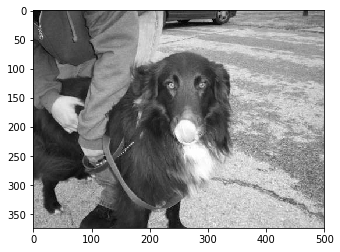

In [0]:
def show_train_image(img): 
  DIR = img[:3] + 's'
  path = os.path.join(DATADIR_train, DIR)
  img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
  plt.imshow(img_array, cmap = "gray")
  plt.show()
  
for img in train_dog_fnames[110:111]:
  print(img)
  show_train_image(img)

dog.6549.jpg


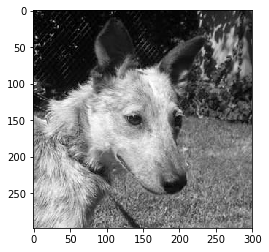

In [0]:
def show_validation_image(img): 
  DIR = img[:3] + 's'
  path = os.path.join(DATADIR_validation, DIR)
  img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
  plt.imshow(img_array, cmap = "gray")
  plt.show()
  
for img in validation_dog_fnames[100:101]:
  print(img)
  show_validation_image(img)

11410.jpg


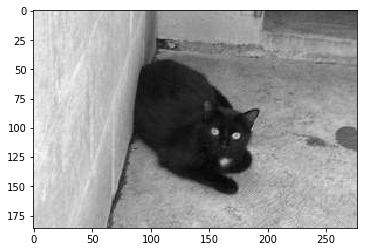

In [0]:
def show_test_image(img):   
  path = os.path.join(DATADIR_test, "unlabelled")
  img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
  plt.imshow(img_array, cmap = "gray")
  plt.show()
  
for img in test_fnames[100:101]:
  print(img)
  show_test_image(img)

#### 3. Focus on one image

In [0]:
def get_image_array(img):
  DIR = img[:3] + 's'
  path = os.path.join(DATADIR_train, DIR)  # could also get img from validation, DATADIR_validation
  img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
  return img_array
  
img_arr = get_image_array("dog.5761.jpg") 
print(img_arr)

[[124 125 125 ... 131 131 130]
 [125 125 125 ... 131 131 130]
 [125 125 125 ... 131 131 130]
 ...
 [101  97  92 ... 191 190 189]
 [101  97  93 ... 188 185 181]
 [ 97  94  91 ... 183 178 173]]


In [0]:
print("The width, height of this particular image are:", img_arr.shape)
print("Minimum value of the pixal:", min([min(_) for _ in img_arr]))  
print("Maximum value of the pixal:", max([max(_) for _ in img_arr]))

The width, height of this particular image are: (375, 499)
Minimum value of the pixal: 3
Maximum value of the pixal: 255


 Get the min, and max for the pixel, for data normalization latter

#### 3.1. Resize the picture smaller to 50 * 50 as an example and check whether the picture is still visible

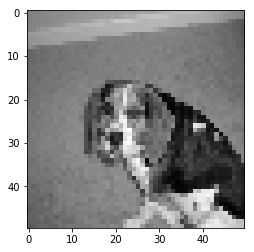

In [0]:
IMG_SIZE = 50
new_array_50 = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array_50, cmap = "gray")
plt.show()

The 50 * 50 pixel is not Clear, try 150 * 150

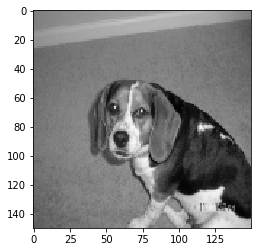

In [0]:
IMG_SIZE = 150
new_array_150 = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array_150, cmap = "gray")
plt.show()

150 * 150 looks ok, use the 150 * 150 as the image size for the CNN model

**Note**: Considered to transform each photo into a vector (vector dimension = 150 * 150) first. However since the dimension is equal to or bigger than the 150 * 150, and also the sample size is huge (25,000), it is impractical to do this transformation all together.  

The **ImageDataGenerator** is introduced to deal with this problem, which only deals with a small dataset each time (a batch_size) first instead of transforming the whole datasets all together.

## Step 3. Image visualization

In [0]:
# Parameters for graph; output image in a 4 X 4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

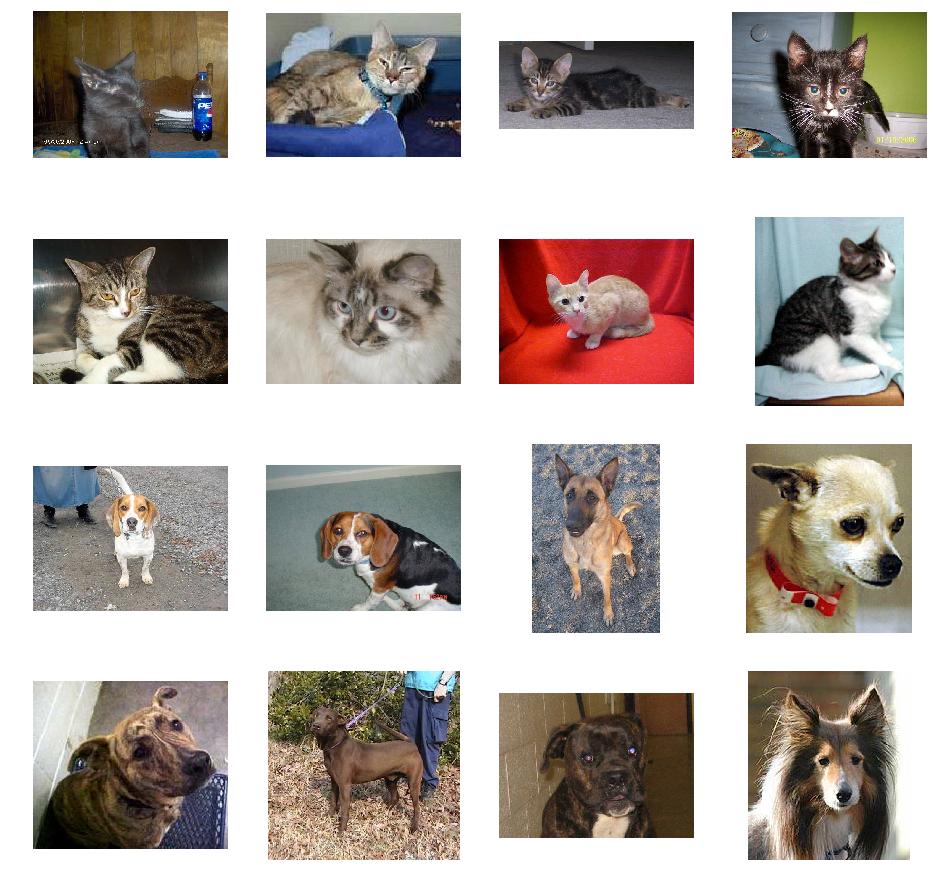

In [0]:
# Set up matplotlib fig, and size it to fit 4 X 4 pictures
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]
for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Step 4. Model building

#### 1. ImageDataGenerator preparation

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.2, 
    zoom_range = 0.2,    
    horizontal_flip = True)  # augumentation to add noise to data: shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True

val_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.2, 
    zoom_range = 0.2,    
    horizontal_flip = True)


test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 100

train_generator = train_datagen.flow_from_directory("/content/dogs-vs-cats/train", class_mode = "binary", target_size = (150, 150), batch_size = batch_size)
validation_generator = val_datagen.flow_from_directory("/content/dogs-vs-cats/validation", class_mode = 'binary', target_size = (150, 150), batch_size = batch_size)
test_generator = test_datagen.flow_from_directory("/content/dogs-vs-cats/test", target_size = (150, 150), batch_size = batch_size, class_mode = None, shuffle = False )

batchX, batchy = train_generator.next()
print("Batch shape = {}, min = {}, max = {}".format(batchX.shape, batchX.min(), batchX.max()))

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
Batch shape = (100, 150, 150, 3), min = 0.0, max = 1.0


##### Flow_from_directory parameters:
1. batch_size = 100 (32 by default)
2. class_mode = "binary", ("categorical" for multi-class classification)
3. "shuffle" = False if need to returen batches in a deterministic order when evaluating a model
4. "target_size" = (150, 150 ) ((256, 256) by default)


In [0]:
# define CNN model
model = Sequential()

model.add(Conv2D(32, kernel_size = (3, 3), 
                 activation = 'relu', input_shape = (150, 150, 3)))
model.add(MaxPooling2D(2, 2))
# --> matrix [74, 74, 3, 32]

model.add(Conv2D(32, (3, 3), activation = 'relu'))#kernel_initializer='he_uniform'
model.add(MaxPooling2D((2, 2)))

# --> matrix [36, 36, (3, 32), 32]


model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))

# --> matrix [17, 17, (3, 32, 32), 64]

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))

# --> matrix [8, 8, (3, 32, 32, 64), 128]


model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))

# --> matrix [3, 3, (3, 32, 32, 64, 128), 64]

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation ='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 15, 15, 128)      

#### 2. Fitting/Training the model

In [0]:
# fit model
steps_per_epoch = train_generator.n//train_generator.batch_size 
validation_steps = validation_generator.n//validation_generator.batch_size

history = model.fit_generator(
    train_generator, 
    steps_per_epoch = steps_per_epoch,
    epochs = 30,         
    validation_data = validation_generator,
    validation_steps = validation_steps)

Epoch 1/30
225/225 [==============================] - 163s 725ms/step - loss: 0.6750 - acc: 0.5691 - val_loss: 0.6197 - val_acc: 0.6560
Epoch 2/30
225/225 [==============================] - 157s 697ms/step - loss: 0.5873 - acc: 0.6905 - val_loss: 0.5317 - val_acc: 0.7416
Epoch 3/30
225/225 [==============================] - 160s 713ms/step - loss: 0.5173 - acc: 0.7523 - val_loss: 0.4849 - val_acc: 0.7684
Epoch 4/30
225/225 [==============================] - 162s 719ms/step - loss: 0.4463 - acc: 0.7952 - val_loss: 0.4014 - val_acc: 0.8212
Epoch 5/30
225/225 [==============================] - 161s 717ms/step - loss: 0.4039 - acc: 0.8167 - val_loss: 0.3955 - val_acc: 0.8212
Epoch 6/30
225/225 [==============================] - 161s 714ms/step - loss: 0.3562 - acc: 0.8458 - val_loss: 0.3274 - val_acc: 0.8524
Epoch 7/30
225/225 [==============================] - 159s 705ms/step - loss: 0.3289 - acc: 0.8590 - val_loss: 0.3446 - val_acc: 0.8396
Epoch 8/30
225/225 [============================

#### 3. Evaluating the model

In [0]:
validation_steps = validation_generator.n//validation_generator.batch_size 

result = model.evaluate_generator(generator = validation_generator, steps = validation_steps)
print("The validation accuracy: {:.4f}".format(result[1]))
print("The validation loss: {:.4f}".format(result[0]))

The validation accuracy: 0.9200
The validation loss: 0.2049


#### 4. More Analysis of Accuracy and Loss for the Model

Visualization of the training/validation accuracy and loss during training

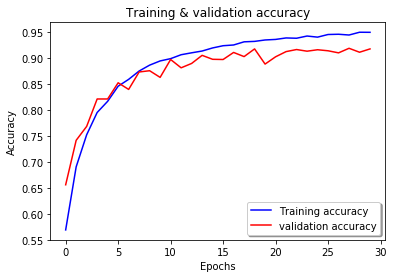

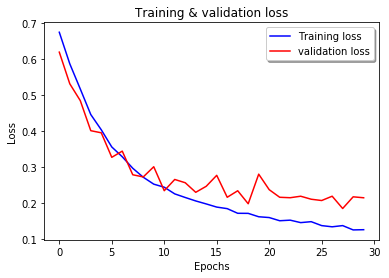

In [0]:
epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs, history.history['acc'],  color = 'b', label = 'Training accuracy')
plt.plot  ( epochs, history.history['val_acc'], color = 'r', label = 'validation accuracy')
plt.title ('Training & validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best', shadow=True)
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs, history.history['loss' ], color = 'b', label = 'Training loss')
plt.plot  ( epochs, history.history['val_loss'] , color = 'r', label = 'validation loss')
plt.title ('Training & validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best', shadow=True)
plt.show()

## Step 5. Predicting

We need to reset the test_generator before whenever we call the predict_generator. This is important, if we forget to reset the test_generator we will get outputs in a wired order. 

In [0]:
step_size_test = test_generator.n//test_generator.batch_size
test_generator.reset()
predictions = model.predict_generator(test_generator, steps = step_size_test, verbose = 1)

125/125 [==============================] - 32s 254ms/step


#### 1 Take several pictures as examples, and get the predicted probabilities and compare with the image to determine the accuracy of the model.

In [0]:
test_images = test_generator.next()[:5]
sub_filesnames = test_generator.filenames[:5]
probabilities = model.predict(test_images)

The probabilities that this image being a dog is:0.9999203681945801
Image: 1.jpg


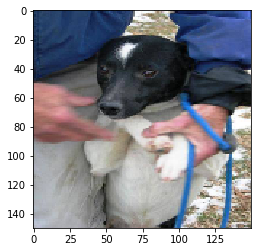


The probabilities that this image being a dog is:2.9802322387695312e-08
Image: 10.jpg


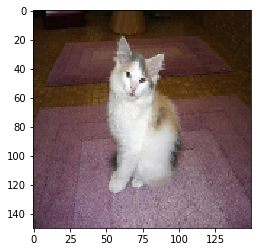


The probabilities that this image being a dog is:0.7940976619720459
Image: 100.jpg


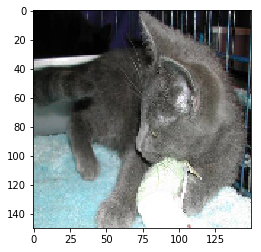


The probabilities that this image being a dog is:0.9997636675834656
Image: 1000.jpg


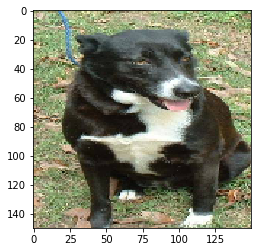


The probabilities that this image being a dog is:0.9998413324356079
Image: 10000.jpg


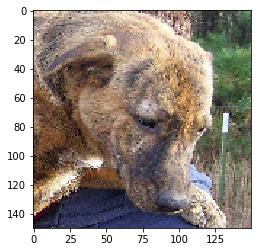

In [0]:
for i in range(len(sub_filesnames)):
  print("The probabilities that this image being a dog is:{}".format(probabilities[i][0])) 
  print("Image:", sub_filesnames[i][11:])
  plt.imshow(test_images[i])
  plt.show()
  print()

#### 2 Label the images based on the predicted probabilities

- If probability >= 0.5, class as 1, label **dog**
- If probability < 0.5, class as 0, label **cat**

In [0]:
predicted_classes = []
for prediction in predictions:
  if prediction >= 0.5:
    predicted_classes.append(1)
  else:
    predicted_classes.append(0)

## Step 6. Save the results to a CSV file, and submit to *Kaggle*

In [0]:
filenames = test_generator.filenames
filenames = [filename[11:-4] for filename in filenames]
results = pd.DataFrame({"id":filenames,                                                  
                       "label": predicted_classes}) 
print(results[:10])
results.to_csv("/content/dogs-vs-cats/dogs_cats.csv", index = False)

      id  label
0      1      1
1     10      0
2    100      1
3   1000      1
4  10000      1
5  10001      0
6  10002      0
7  10003      1
8  10004      1
9  10005      0


##### Cross check whether the label is correct based on the image

1.jpg


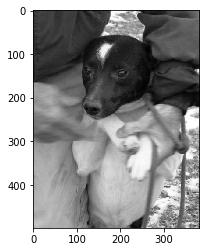

1000.jpg


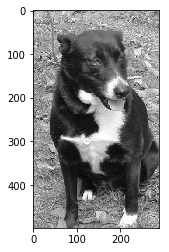

10000.jpg


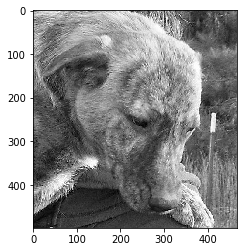

10003.jpg


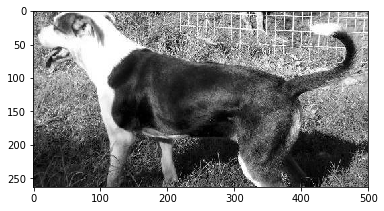

In [0]:
def show_test_image(img):   
  path = os.path.join(DATADIR_test, "unlabelled")
  img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
  plt.imshow(img_array, cmap = "gray")
  plt.show()
  
res = ["1.jpg", "1000.jpg", "10000.jpg", "10003.jpg"]
for img in res:
  print(img)
  show_test_image(img)

### References
URL_1 = "https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/"

URL_2 = "https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/"